# Pendulum-v0 DDPG

In [13]:
#from my_ddpg_pendulum_v0 import ReplayBuffer, DDPG
from my_ddpg_ac import Actor, Critic, OUNoise
import numpy as np
import gym
import pylab
import numpy as np
import tensorflow as tf
import sys

from keras import layers, models, optimizers
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU

import random
from collections import namedtuple, deque 



In [14]:
class ReplayBuffer:
    """fixed-size buffer to store experience tuples"""

    def __init__(self, buffer_size, batch_size):
        """initialize a replaybuffer object.
        Params
        ======
            buffer_size:  max size of buffer
            batch_size: size of each training batch
        """
        self.memory = deque(maxlen=buffer_size) #100k
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size=64):
        "Randomly return a batch of experience from memory"
        return random.sample(self.memory, k=self.batch_size)

    def __len__(self):
        """Return the current size of internal memory"""
        return len(self.memory)


In [15]:
class DDPG():
    """Reinforcement learning agent that learns using DDPG"""
    #change from action size to action range I think
    def __init__(self, state_size, action_size, action_max):
        self.state_size = state_size
        self.action_size = action_size #1
        self.action_range = action_max * 2
        self.action_low = action_max - self.action_range
        self.action_high = action_max
        print("self.action_low", self.action_low) #-2.
        print("self.action_high", self.action_high) #2.
        #Actor Policy Model 
        self.actor_local = Actor(self.state_size, self.action_size, \
            self.action_low, self.action_high)
        self.actor_target = Actor(self.state_size, self.action_size, \
            self.action_low, self.action_high)

        #Critic Value Model
        self.critic_local = Critic(self.state_size, self.action_size)
        self.critic_target = Critic(self.state_size, self.action_size)

        #initialize target model parameters with local model parameters
        self.critic_target.model.set_weights(self.critic_local.model.get_weights())
        self.actor_target.model.set_weights(self.actor_local.model.get_weights())

        #Noise process
        self.exploration_mu = 0
        self.exploration_theta = 0.15
        self.exploration_sigma = 0.2
        self.noise = OUNoise(self.action_size, self.exploration_mu, \
            self.exploration_theta, self.exploration_sigma)

        #replay memory
        self.buffer_size = 100000
        self.batch_size = 64
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size)

        #Algorithm parameters
        self.gamma = 0.99 #discount parameter for critic TD error
        self.tau = 0.001 #soft update parameter
        """
        self.tau_actor = 0.1
        self.tau_critic = 0.5 
        """
        self.render = True

        self.load = False

        if self.load:
            self.actor.load("./saved_models/DDPG_pendulum_v0_actor.h5")
            self.critic.load("./saved_models/DDPG_pendulum_v0_critic.h5")
            
    #resets noise and env and outputs the initial state 
    def reset_episode(self):
        self.noise.reset()
        state = env.reset()
        self.last_state = state 
        return state

    #adds the experience to memory and calls learn fxn if memory sufficient for batch
    #
    def step(self, action, reward, next_state, done):
        self.memory.add(self.last_state, action, reward, next_state, \
            done)
       
        #Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)
        #Roll over last state and action
        self.last_state = next_state

    def act(self, state):
        """Returns actions for given state(s) as per current policy"""
        state = np.reshape(state, [-1, self.state_size])
        raw_action = self.actor_local.model.predict(state)[0]
        #rescale output to -2 to 2
        scaled_action = raw_action * 2
        noise = self.noise.sample()
        action = np.clip((scaled_action + noise), -2, 2) #add noise for exploration
        return action 

    def learn(self, experiences):
        """update policy and value parameters using given batch of 
        experience tuples"""
        #convert experience tuples to separate arrays for each element
        #(states, actions, rewards, etc)
        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.array([e.action for e in experiences if e is not None]) \
            .astype(np.float32).reshape(-1, self.action_size)
        rewards = np.array([e.reward for e in experiences if e is not None]) \
            .astype(np.float32).reshape(-1, 1)
        dones = np.array([e.done for e in experiences if e is not None]) \
            .astype(np.uint8).reshape(-1, 1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None])               

        #get predicted next_state actions and Q values from target models
        actions_next = self.actor_target.model.predict_on_batch(next_states)
        #use the actions from target actor to find target Qs of next actions
        Q_targets_next = self.critic_target.model.predict_on_batch([next_states, actions_next])
        #compute Q targets for current states using Q targets next from target_model
        #and train local critic model
        Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)
        self.critic_local.model.train_on_batch(x=[states, actions], y=Q_targets)

        """called to get dQ(s,a)/da from critic
        self.get_action_gradients = K.function(inputs=[*self.model.input, K.learning_phase()], outputs=action_gradients)
        """
        action_gradients = np.reshape(self.critic_local.get_action_gradients([states, actions, 0]), \
            (-1, self.action_size))

        """use the dQ(s,a)/da from critic to train actor
        called:  
        self.train_fn = K.function(inputs=[self.model.input, action_gradients, K.learning_phase()], \
            outputs=[], updates=updates_op) no outputs
        """
        self.actor_local.train_fn([states, action_gradients, 1])

        #soft update target models, could use different tau for critic and actor
        self.soft_update(self.critic_local.model, self.critic_target.model)
        self.soft_update(self.actor_local.model, self.actor_target.model)

        #soft update target models
    def soft_update(self, local_model, target_model):
        """soft update model parameters"""
        local_weights = np.array(local_model.get_weights())
        target_weights = np.array(target_model.get_weights())

        assert len(local_weights) == len(target_weights)
        #weights to train target get updated using polyak formula where tau = [0,1]
        #closer to 1 than 0 usually
        new_weights = self.tau * local_weights + (1 - self.tau) * target_weights
        target_model.set_weights(new_weights)

In [16]:
EPISODES = 1000

state_size, action_size, action_bound 3 1 [2.]
self.action_low [-2.]
self.action_high [2.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
states (InputLayer)          (None, 3)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                128       
_________________________________________________________________
activation_33 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                2112      
_________________________________________________________________
activation_34 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
___________________________________________________

/media/nobu/Ubuntu Backup/_DeepLearning/_1openAI/_1gym/reinforcement-learning-copied/_1my_imps/continuous/Pendulum-v0/my_ddpg_ac.py:65: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ra..., inputs=Tensor("st...)`
  self.model = models.Model(input=states, outputs=(raw_actions))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
states (InputLayer)          (None, 3)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                128       
_________________________________________________________________
activation_36 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                2112      
_________________________________________________________________
activation_37 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_38 (Activation)   (None, 32)                0         
__________

Instructions for updating:
Use tf.cast instead.
episode: 0 score: -1705.9136354877292 best: -1705.91 mean: -1705.91 std: 0.0
episode: 1 score: -1294.1876698609503 best: -1294.19 mean: -1500.05 std: 205.86
episode: 2 score: -1485.6185492002496 best: -1294.19 mean: -1495.24 std: 168.22
episode: 3 score: -1055.9106003486338 best: -1055.91 mean: -1385.41 std: 239.61
episode: 4 score: -1624.738930734448 best: -1055.91 mean: -1433.27 std: 234.73


KeyboardInterrupt: 

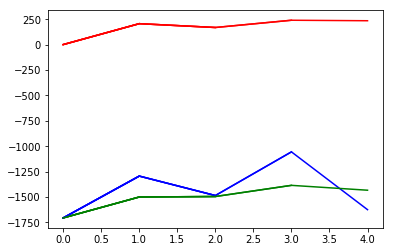

In [17]:
if __name__== "__main__":

    env=gym.make("Pendulum-v0")

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    action_bound = env.action_space.high
    print("state_size, action_size, action_bound", state_size, action_size, action_bound)
    #ensure action bound is symmetric
    assert (env.action_space.high == -env.action_space.low)

    agent = DDPG(state_size, action_size, action_bound)

    scores, episodes, means, stds = [], [], [], []

    position = 0

    for episode in range(EPISODES):
        done = False
        score = 0
        mean, std, large = 0, 0, 0
        state = agent.reset_episode()

        while not done:
            if agent.render:
                env.render()

            #get action from network
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            """adjust reward for incremental improvements in position
            special reward for mountaincarcontinuous
            state[0] is the cart position from -1.2 to 0.6""" 
            #reward += state[0] + 0.5
            #save experience in memory
            agent.step(action=action, reward=reward, next_state=next_state, done=done)
            
            #bookkeeping
            score += reward
            state = next_state

            if done:
#retype from here
                scores.append(score)
                mean = np.mean(scores[-min(10, len(scores)):])
                means.append(mean)
                std = np.std(scores[-min(10, len(scores)):])
                stds.append(std)
                large = max(scores)
                episodes.append(episode)
                pylab.plot(episodes, scores, 'b')
                pylab.plot(episodes, means, 'g')
                pylab.plot(episodes, stds, 'r')
                pylab.savefig("./saved_graphs/DDPG_pendulum_v0.png")
                print('episode:', episode, 'score:', score, 'best:', round(large,2), 'mean:', round(mean,2), 'std:', round(std, 2))
                if np.mean(scores[-min(100, len(scores)):]) >= 90.0:
                    sys.exit()
"""                  
        if episode % 50 == 0:
            agent.actor_local.save_weights("./saved_models/DDPG_cartpoleV1_actor.h5")
            agent.critic_local.save_weights("./saved_models/DDPG_cartpoleV1_critic.h5")
"""
